In [ ]:
# =====================================================
#     Tên: Real Estate Price Prediction
#     Nghiên cứu khoa học: "Nghiên cứu tối ưu mô hình kết hợp
#     trong việc dự đoán giá nhà tại Hà Nội"
#     Mô hình sử dụng: Linear Regression & Random Forest
# =====================================================

In [2]:
# -------------------------------------------------
# 0. CÀI THƯ VIỆN (Colab cài mới nhất đã hỗ trợ GPU)
# -------------------------------------------------
!pip install -U xgboost optuna --quiet pandas scikit-learn

In [3]:
# -------------------------------------------------
# 1. IMPORT & ĐỌC DỮ LIỆU
# -------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path

# --- tải/đọc CSV ---
DATA_PATH = Path("data_processing.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Không tìm thấy file: {DATA_PATH}")
data = pd.read_csv(DATA_PATH)

target = "price"
y = data[target]
X = data.drop(columns=[target])

In [4]:
# -------------------------------------------------
# 2. TIỀN XỬ LÝ: ColumnTransformer + Pipeline
# -------------------------------------------------
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_cols  = X.select_dtypes(include=["int64", "float64"]).columns
bool_cols = X.select_dtypes(include=["bool"]).columns  # 1‑hot district

preprocess = ColumnTransformer([
    ("num",  StandardScaler(),   num_cols),
    ("bool", "passthrough",      bool_cols)  # giữ nguyên 0/1
])

In [5]:
# -------------------------------------------------
# 3. ĐỊNH NGHĨA RMSLE & SCORER
# -------------------------------------------------
from sklearn.metrics import make_scorer, mean_squared_log_error

def rmsle(y_true, y_pred):
    # Cắt giá trị về >= 0 để tránh log(âm)
    y_true = np.clip(y_true, 0, None)
    y_pred = np.clip(y_pred, 0, None)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Tạo scorer cho cross_val_score,
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [6]:
# -------------------------------------------------
# 4. TÁCH TRAIN / TEST (80 % / 20 %)
# -------------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
# -------------------------------------------------
# 5. OPTUNA: TUNE RANDOM FOREST (CPU)
# -------------------------------------------------
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):

    params = {
        "n_estimators"      : trial.suggest_int("n_estimators", 300, 1500),
        "max_depth"         : trial.suggest_int("max_depth", 4, 30),
        "max_features"      : trial.suggest_float("max_features", 0.3, 1.0),
        "min_samples_split" : trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf"  : trial.suggest_int("min_samples_leaf", 1, 10),
        "bootstrap"         : trial.suggest_categorical("bootstrap", [True, False]),
        "random_state"      : 42,
        "n_jobs"            : -1                # đa luồng CPU
    }

    model = Pipeline([
        ("prep", preprocess),                   # scaler + one‑hot
        ("rf",   RandomForestRegressor(**params))
    ])

    # 5‑fold CV – Optuna sẽ MINIMIZE RMSLE
    score = -cross_val_score(model, X_train, y_train,
                             cv=5,
                             scoring=rmsle_scorer,
                             n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best RMSLE (CV):", study.best_value)
print("Best params:", study.best_params)

C:\Users\tpc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-23 14:59:58,998] A new study created in memory with name: no-name-4610e17f-2e8a-4f3a-a8c7-d58ce8417ba9
Best trial: 0. Best value: 0.571902:   1%|          | 1/100 [00:23<39:35, 24.00s/it]

[I 2025-04-23 15:00:22,996] Trial 0 finished with value: 0.5719021129490087 and parameters: {'n_estimators': 633, 'max_depth': 5, 'max_features': 0.40133029709620266, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.5719021129490087.


Best trial: 1. Best value: 0.223784:   2%|▏         | 2/100 [05:28<5:08:57, 189.16s/it]

[I 2025-04-23 15:05:27,741] Trial 1 finished with value: 0.22378407661468094 and parameters: {'n_estimators': 1162, 'max_depth': 22, 'max_features': 0.6448212411108663, 'min_samples_split': 9, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 1 with value: 0.22378407661468094.


Best trial: 1. Best value: 0.223784:   3%|▎         | 3/100 [08:14<4:48:36, 178.52s/it]

[I 2025-04-23 15:08:13,624] Trial 2 finished with value: 0.2533850292640146 and parameters: {'n_estimators': 1281, 'max_depth': 16, 'max_features': 0.394984494926313, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 0.22378407661468094.


Best trial: 3. Best value: 0.223066:   4%|▍         | 4/100 [12:12<5:23:08, 201.96s/it]

[I 2025-04-23 15:12:11,447] Trial 3 finished with value: 0.22306605911108274 and parameters: {'n_estimators': 976, 'max_depth': 26, 'max_features': 0.4922092297956341, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 3 with value: 0.22306605911108274.


Best trial: 3. Best value: 0.223066:   5%|▌         | 5/100 [16:44<5:59:44, 227.21s/it]

[I 2025-04-23 15:16:43,495] Trial 4 finished with value: 0.23081018626193614 and parameters: {'n_estimators': 1240, 'max_depth': 27, 'max_features': 0.8290274404535778, 'min_samples_split': 9, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 3 with value: 0.22306605911108274.


Best trial: 3. Best value: 0.223066:   6%|▌         | 6/100 [19:50<5:33:55, 213.14s/it]

[I 2025-04-23 15:19:49,292] Trial 5 finished with value: 0.23459748011903264 and parameters: {'n_estimators': 1180, 'max_depth': 24, 'max_features': 0.42835809367705424, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 3 with value: 0.22306605911108274.


Best trial: 3. Best value: 0.223066:   7%|▋         | 7/100 [26:49<7:14:55, 280.60s/it]

[I 2025-04-23 15:26:48,811] Trial 6 finished with value: 0.2256638105690653 and parameters: {'n_estimators': 1435, 'max_depth': 28, 'max_features': 0.7835045856564762, 'min_samples_split': 9, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 3 with value: 0.22306605911108274.


Best trial: 3. Best value: 0.223066:   8%|▊         | 8/100 [30:46<6:48:43, 266.56s/it]

[I 2025-04-23 15:30:45,317] Trial 7 finished with value: 0.23955399977914055 and parameters: {'n_estimators': 1239, 'max_depth': 24, 'max_features': 0.44446958898576616, 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 3 with value: 0.22306605911108274.


Best trial: 3. Best value: 0.223066:   9%|▉         | 9/100 [32:01<5:13:24, 206.65s/it]

[I 2025-04-23 15:32:00,224] Trial 8 finished with value: 0.3375394013092892 and parameters: {'n_estimators': 828, 'max_depth': 13, 'max_features': 0.31230014343247986, 'min_samples_split': 5, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 3 with value: 0.22306605911108274.


Best trial: 3. Best value: 0.223066:  10%|█         | 10/100 [33:08<4:05:16, 163.52s/it]

[I 2025-04-23 15:33:07,147] Trial 9 finished with value: 0.2612393358497983 and parameters: {'n_estimators': 412, 'max_depth': 26, 'max_features': 0.3981675813023783, 'min_samples_split': 7, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 3 with value: 0.22306605911108274.


Best trial: 3. Best value: 0.223066:  11%|█         | 11/100 [35:41<3:57:52, 160.36s/it]

[I 2025-04-23 15:35:40,367] Trial 10 finished with value: 0.23207544318138423 and parameters: {'n_estimators': 928, 'max_depth': 18, 'max_features': 0.5848275989959947, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 3 with value: 0.22306605911108274.


Best trial: 3. Best value: 0.223066:  12%|█▏        | 12/100 [38:30<3:58:56, 162.92s/it]

[I 2025-04-23 15:38:29,129] Trial 11 finished with value: 0.24419723316076034 and parameters: {'n_estimators': 997, 'max_depth': 21, 'max_features': 0.6530373617456736, 'min_samples_split': 2, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 3 with value: 0.22306605911108274.


Best trial: 3. Best value: 0.223066:  13%|█▎        | 13/100 [40:37<3:40:49, 152.29s/it]

[I 2025-04-23 15:40:36,971] Trial 12 finished with value: 0.2324732360903592 and parameters: {'n_estimators': 723, 'max_depth': 30, 'max_features': 0.6121561961085669, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 3 with value: 0.22306605911108274.


Best trial: 13. Best value: 0.196488:  14%|█▍        | 14/100 [47:13<5:23:33, 225.74s/it]

[I 2025-04-23 15:47:12,423] Trial 13 finished with value: 0.19648802741106283 and parameters: {'n_estimators': 1056, 'max_depth': 20, 'max_features': 0.9400700840610658, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 13 with value: 0.19648802741106283.


Best trial: 14. Best value: 0.19408:  15%|█▌        | 15/100 [52:54<6:09:12, 260.61s/it] 

[I 2025-04-23 15:52:53,856] Trial 14 finished with value: 0.1940802563319746 and parameters: {'n_estimators': 969, 'max_depth': 18, 'max_features': 0.9556731388298033, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 14. Best value: 0.19408:  16%|█▌        | 16/100 [55:01<5:08:24, 220.29s/it]

[I 2025-04-23 15:55:00,516] Trial 15 finished with value: 0.2642878918539761 and parameters: {'n_estimators': 588, 'max_depth': 11, 'max_features': 0.9918748675371727, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 14. Best value: 0.19408:  17%|█▋        | 17/100 [1:01:03<6:03:32, 262.80s/it]

[I 2025-04-23 16:01:02,172] Trial 16 finished with value: 0.19500022107111076 and parameters: {'n_estimators': 1060, 'max_depth': 17, 'max_features': 0.9996252196807298, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 14. Best value: 0.19408:  18%|█▊        | 18/100 [1:04:10<5:27:58, 239.98s/it]

[I 2025-04-23 16:04:09,035] Trial 17 finished with value: 0.2483738734760838 and parameters: {'n_estimators': 802, 'max_depth': 14, 'max_features': 0.8717527843721684, 'min_samples_split': 4, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 14. Best value: 0.19408:  19%|█▉        | 19/100 [1:07:13<5:01:02, 222.99s/it]

[I 2025-04-23 16:07:12,445] Trial 18 finished with value: 0.3231978681329384 and parameters: {'n_estimators': 1420, 'max_depth': 9, 'max_features': 0.7462385211054927, 'min_samples_split': 7, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 14. Best value: 0.19408:  20%|██        | 20/100 [1:09:13<4:16:07, 192.10s/it]

[I 2025-04-23 16:09:12,538] Trial 19 finished with value: 0.20046167635798834 and parameters: {'n_estimators': 375, 'max_depth': 17, 'max_features': 0.9368288185266902, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 14. Best value: 0.19408:  21%|██        | 21/100 [1:11:55<4:00:56, 183.00s/it]

[I 2025-04-23 16:11:54,315] Trial 20 finished with value: 0.3810823923529597 and parameters: {'n_estimators': 1135, 'max_depth': 8, 'max_features': 0.9994201855656767, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 14. Best value: 0.19408:  22%|██▏       | 22/100 [1:18:10<5:12:42, 240.54s/it]

[I 2025-04-23 16:18:09,056] Trial 21 finished with value: 0.19751037235804333 and parameters: {'n_estimators': 1058, 'max_depth': 20, 'max_features': 0.909063463695456, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 14. Best value: 0.19408:  23%|██▎       | 23/100 [1:24:30<6:02:38, 282.58s/it]

[I 2025-04-23 16:24:29,685] Trial 22 finished with value: 0.19515497859905692 and parameters: {'n_estimators': 1084, 'max_depth': 19, 'max_features': 0.9394075407617397, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 14. Best value: 0.19408:  24%|██▍       | 24/100 [1:28:07<5:32:56, 262.84s/it]

[I 2025-04-23 16:28:06,487] Trial 23 finished with value: 0.21107243564909214 and parameters: {'n_estimators': 858, 'max_depth': 15, 'max_features': 0.8488671462686563, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 14. Best value: 0.19408:  25%|██▌       | 25/100 [1:34:38<6:16:44, 301.39s/it]

[I 2025-04-23 16:34:37,804] Trial 24 finished with value: 0.20421078050022973 and parameters: {'n_estimators': 1359, 'max_depth': 18, 'max_features': 0.7521413213182375, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 14. Best value: 0.19408:  26%|██▌       | 26/100 [1:38:40<5:49:31, 283.40s/it]

[I 2025-04-23 16:38:39,223] Trial 25 finished with value: 0.2424394062348926 and parameters: {'n_estimators': 1067, 'max_depth': 12, 'max_features': 0.9538435042997716, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 14. Best value: 0.19408:  27%|██▋       | 27/100 [1:44:25<6:07:14, 301.84s/it]

[I 2025-04-23 16:44:24,079] Trial 26 finished with value: 0.20207823016718462 and parameters: {'n_estimators': 903, 'max_depth': 23, 'max_features': 0.8905891102203352, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 14. Best value: 0.19408:  28%|██▊       | 28/100 [1:48:02<5:31:42, 276.43s/it]

[I 2025-04-23 16:48:01,231] Trial 27 finished with value: 0.21733039051186184 and parameters: {'n_estimators': 754, 'max_depth': 19, 'max_features': 0.7984604305315252, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 14. Best value: 0.19408:  29%|██▉       | 29/100 [1:53:24<5:43:15, 290.08s/it]

[I 2025-04-23 16:53:23,156] Trial 28 finished with value: 0.20448494780506069 and parameters: {'n_estimators': 1333, 'max_depth': 16, 'max_features': 0.6939961177325251, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 14. Best value: 0.19408:  30%|███       | 30/100 [1:54:21<4:16:48, 220.12s/it]

[I 2025-04-23 16:54:20,036] Trial 29 finished with value: 0.4941846412714425 and parameters: {'n_estimators': 506, 'max_depth': 6, 'max_features': 0.9526454924413026, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 14. Best value: 0.19408:  31%|███       | 31/100 [1:55:07<3:13:04, 167.90s/it]

[I 2025-04-23 16:55:06,082] Trial 30 finished with value: 0.6745947997503483 and parameters: {'n_estimators': 668, 'max_depth': 4, 'max_features': 0.89763059841788, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 14 with value: 0.1940802563319746.


Best trial: 31. Best value: 0.191494:  32%|███▏      | 32/100 [2:01:53<4:31:21, 239.43s/it]

[I 2025-04-23 17:01:52,430] Trial 31 finished with value: 0.1914937481196532 and parameters: {'n_estimators': 1053, 'max_depth': 20, 'max_features': 0.9980171012891663, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 31 with value: 0.1914937481196532.


Best trial: 32. Best value: 0.191347:  33%|███▎      | 33/100 [2:09:39<5:43:22, 307.51s/it]

[I 2025-04-23 17:09:38,729] Trial 32 finished with value: 0.19134664572354138 and parameters: {'n_estimators': 1123, 'max_depth': 22, 'max_features': 0.9985898082563698, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  34%|███▍      | 34/100 [2:16:01<6:02:40, 329.70s/it]

[I 2025-04-23 17:16:00,264] Trial 33 finished with value: 0.1939128002647762 and parameters: {'n_estimators': 977, 'max_depth': 22, 'max_features': 0.9967312147483443, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  35%|███▌      | 35/100 [2:22:08<6:09:28, 341.06s/it]

[I 2025-04-23 17:22:07,826] Trial 34 finished with value: 0.19386378270200344 and parameters: {'n_estimators': 964, 'max_depth': 22, 'max_features': 0.9764996955783638, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  36%|███▌      | 36/100 [2:28:36<6:18:48, 355.13s/it]

[I 2025-04-23 17:28:35,774] Trial 35 finished with value: 0.20723402601777124 and parameters: {'n_estimators': 1139, 'max_depth': 22, 'max_features': 0.8477324964798378, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  37%|███▋      | 37/100 [2:33:46<5:58:35, 341.51s/it]

[I 2025-04-23 17:33:45,520] Trial 36 finished with value: 0.22478096945176004 and parameters: {'n_estimators': 1203, 'max_depth': 24, 'max_features': 0.975858273776628, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  38%|███▊      | 38/100 [2:39:15<5:48:54, 337.66s/it]

[I 2025-04-23 17:39:14,183] Trial 37 finished with value: 0.22116012618798572 and parameters: {'n_estimators': 984, 'max_depth': 22, 'max_features': 0.9158891462431218, 'min_samples_split': 9, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  39%|███▉      | 39/100 [2:42:33<5:00:47, 295.87s/it]

[I 2025-04-23 17:42:32,542] Trial 38 finished with value: 0.22761794892813003 and parameters: {'n_estimators': 904, 'max_depth': 26, 'max_features': 0.5350843657056548, 'min_samples_split': 9, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  40%|████      | 40/100 [2:47:25<4:54:41, 294.70s/it]

[I 2025-04-23 17:47:24,519] Trial 39 finished with value: 0.2270219436214537 and parameters: {'n_estimators': 1271, 'max_depth': 25, 'max_features': 0.8682499414680567, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  41%|████      | 41/100 [2:52:57<5:00:46, 305.87s/it]

[I 2025-04-23 17:52:56,455] Trial 40 finished with value: 0.21374397882792717 and parameters: {'n_estimators': 1005, 'max_depth': 28, 'max_features': 0.7963232158429946, 'min_samples_split': 7, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  42%|████▏     | 42/100 [2:58:57<5:11:26, 322.18s/it]

[I 2025-04-23 17:58:56,678] Trial 41 finished with value: 0.19321491556147002 and parameters: {'n_estimators': 950, 'max_depth': 21, 'max_features': 0.9723122612201044, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  43%|████▎     | 43/100 [3:05:55<5:33:11, 350.73s/it]

[I 2025-04-23 18:05:54,040] Trial 42 finished with value: 0.19719329029770666 and parameters: {'n_estimators': 1130, 'max_depth': 21, 'max_features': 0.971510607738383, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  44%|████▍     | 44/100 [3:11:04<5:15:52, 338.43s/it]

[I 2025-04-23 18:11:03,775] Trial 43 finished with value: 0.19659734030186113 and parameters: {'n_estimators': 850, 'max_depth': 23, 'max_features': 0.9159671226404609, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  45%|████▌     | 45/100 [3:16:54<5:13:14, 341.72s/it]

[I 2025-04-23 18:16:53,167] Trial 44 finished with value: 0.19469022901061045 and parameters: {'n_estimators': 950, 'max_depth': 21, 'max_features': 0.9730538934016962, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  46%|████▌     | 46/100 [3:20:19<4:30:38, 300.71s/it]

[I 2025-04-23 18:20:18,176] Trial 45 finished with value: 0.24283527967805796 and parameters: {'n_estimators': 1205, 'max_depth': 23, 'max_features': 0.3521297858462362, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  47%|████▋     | 47/100 [3:23:16<3:52:54, 263.67s/it]

[I 2025-04-23 18:23:15,422] Trial 46 finished with value: 0.22445691234143833 and parameters: {'n_estimators': 779, 'max_depth': 25, 'max_features': 0.8245453484224248, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  48%|████▊     | 48/100 [3:28:50<4:06:45, 284.73s/it]

[I 2025-04-23 18:28:49,281] Trial 47 finished with value: 0.21286599756704144 and parameters: {'n_estimators': 1016, 'max_depth': 20, 'max_features': 0.9218972595155704, 'min_samples_split': 7, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  49%|████▉     | 49/100 [3:33:20<3:58:17, 280.34s/it]

[I 2025-04-23 18:33:19,378] Trial 48 finished with value: 0.22122814805397226 and parameters: {'n_estimators': 874, 'max_depth': 27, 'max_features': 0.8769229921764609, 'min_samples_split': 8, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  50%|█████     | 50/100 [3:37:54<3:51:56, 278.33s/it]

[I 2025-04-23 18:37:53,019] Trial 49 finished with value: 0.22557914323908204 and parameters: {'n_estimators': 1103, 'max_depth': 24, 'max_features': 0.9737228822367057, 'min_samples_split': 9, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  51%|█████     | 51/100 [3:43:27<4:00:46, 294.83s/it]

[I 2025-04-23 18:43:26,367] Trial 50 finished with value: 0.19218212064743373 and parameters: {'n_estimators': 921, 'max_depth': 19, 'max_features': 0.9949363472396389, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  52%|█████▏    | 52/100 [3:49:06<4:06:28, 308.10s/it]

[I 2025-04-23 18:49:05,416] Trial 51 finished with value: 0.19216238310586947 and parameters: {'n_estimators': 931, 'max_depth': 19, 'max_features': 0.9992827860317364, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  53%|█████▎    | 53/100 [3:55:11<4:14:44, 325.21s/it]

[I 2025-04-23 18:55:10,557] Trial 52 finished with value: 0.19407814912860324 and parameters: {'n_estimators': 1025, 'max_depth': 19, 'max_features': 0.9530780423170426, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  54%|█████▍    | 54/100 [4:00:04<4:01:59, 315.63s/it]

[I 2025-04-23 19:00:03,842] Trial 53 finished with value: 0.19787284550596795 and parameters: {'n_estimators': 936, 'max_depth': 16, 'max_features': 0.9964730581119665, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  55%|█████▌    | 55/100 [4:05:00<3:52:07, 309.50s/it]

[I 2025-04-23 19:04:59,019] Trial 54 finished with value: 0.19617706825967987 and parameters: {'n_estimators': 817, 'max_depth': 20, 'max_features': 0.9327592339912829, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  56%|█████▌    | 56/100 [4:08:53<3:30:19, 286.81s/it]

[I 2025-04-23 19:08:52,909] Trial 55 finished with value: 0.19577821420284489 and parameters: {'n_estimators': 718, 'max_depth': 17, 'max_features': 0.9586274153637004, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  57%|█████▋    | 57/100 [4:11:40<2:59:46, 250.85s/it]

[I 2025-04-23 19:11:39,832] Trial 56 finished with value: 0.22825959502264484 and parameters: {'n_estimators': 912, 'max_depth': 18, 'max_features': 0.4790420694241486, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  58%|█████▊    | 58/100 [4:18:05<3:23:37, 290.88s/it]

[I 2025-04-23 19:18:04,084] Trial 57 finished with value: 0.19892850589299108 and parameters: {'n_estimators': 1020, 'max_depth': 22, 'max_features': 0.900348165371249, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  59%|█████▉    | 59/100 [4:25:45<3:53:31, 341.74s/it]

[I 2025-04-23 19:25:44,523] Trial 58 finished with value: 0.19158056807520865 and parameters: {'n_estimators': 1169, 'max_depth': 21, 'max_features': 0.9808839152281683, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  60%|██████    | 60/100 [4:31:49<3:52:15, 348.40s/it]

[I 2025-04-23 19:31:48,460] Trial 59 finished with value: 0.2393241094156841 and parameters: {'n_estimators': 1173, 'max_depth': 21, 'max_features': 0.9318927997315867, 'min_samples_split': 7, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  61%|██████    | 61/100 [4:35:54<3:26:19, 317.42s/it]

[I 2025-04-23 19:35:53,599] Trial 60 finished with value: 0.24344413044987778 and parameters: {'n_estimators': 1241, 'max_depth': 19, 'max_features': 0.8520106643854751, 'min_samples_split': 6, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  62%|██████▏   | 62/100 [4:42:43<3:38:24, 344.85s/it]

[I 2025-04-23 19:42:42,462] Trial 61 finished with value: 0.193637356224224 and parameters: {'n_estimators': 1095, 'max_depth': 20, 'max_features': 0.9751158150599839, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  63%|██████▎   | 63/100 [4:49:17<3:41:40, 359.47s/it]

[I 2025-04-23 19:49:16,030] Trial 62 finished with value: 0.19301980579115785 and parameters: {'n_estimators': 1119, 'max_depth': 18, 'max_features': 0.9980385412860681, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  64%|██████▍   | 64/100 [4:55:37<3:39:23, 365.65s/it]

[I 2025-04-23 19:55:36,100] Trial 63 finished with value: 0.20448694289880937 and parameters: {'n_estimators': 1305, 'max_depth': 15, 'max_features': 0.999221698475832, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  65%|██████▌   | 65/100 [5:01:45<3:33:48, 366.54s/it]

[I 2025-04-23 20:01:44,712] Trial 64 finished with value: 0.19669044160794485 and parameters: {'n_estimators': 1152, 'max_depth': 17, 'max_features': 0.948165687714768, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  66%|██████▌   | 66/100 [5:09:56<3:48:53, 403.93s/it]

[I 2025-04-23 20:09:55,883] Trial 65 finished with value: 0.204590876171798 and parameters: {'n_estimators': 1487, 'max_depth': 19, 'max_features': 0.8862849153916422, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  67%|██████▋   | 67/100 [5:16:10<3:37:06, 394.75s/it]

[I 2025-04-23 20:16:09,217] Trial 66 finished with value: 0.19171150870305723 and parameters: {'n_estimators': 1042, 'max_depth': 18, 'max_features': 0.9796649812924507, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  68%|██████▊   | 68/100 [5:20:38<3:10:18, 356.84s/it]

[I 2025-04-23 20:20:37,593] Trial 67 finished with value: 0.21630755461368034 and parameters: {'n_estimators': 1048, 'max_depth': 14, 'max_features': 0.9305453880599706, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  69%|██████▉   | 69/100 [5:27:00<3:08:16, 364.41s/it]

[I 2025-04-23 20:26:59,677] Trial 68 finished with value: 0.1940829222166484 and parameters: {'n_estimators': 1103, 'max_depth': 18, 'max_features': 0.9576934474376376, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  70%|███████   | 70/100 [5:31:58<2:52:13, 344.44s/it]

[I 2025-04-23 20:31:57,515] Trial 69 finished with value: 0.21311067103610098 and parameters: {'n_estimators': 1177, 'max_depth': 18, 'max_features': 0.6887027691701891, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  71%|███████   | 71/100 [5:38:24<2:52:32, 356.99s/it]

[I 2025-04-23 20:38:23,778] Trial 70 finished with value: 0.19755942679413496 and parameters: {'n_estimators': 1232, 'max_depth': 16, 'max_features': 0.998350538621659, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  72%|███████▏  | 72/100 [5:43:55<2:42:55, 349.11s/it]

[I 2025-04-23 20:43:54,503] Trial 71 finished with value: 0.19143890819116885 and parameters: {'n_estimators': 874, 'max_depth': 20, 'max_features': 0.9763173325106905, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  73%|███████▎  | 73/100 [5:48:57<2:30:47, 335.09s/it]

[I 2025-04-23 20:48:56,868] Trial 72 finished with value: 0.19746660371943717 and parameters: {'n_estimators': 861, 'max_depth': 20, 'max_features': 0.9060143727573748, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  74%|███████▍  | 74/100 [5:55:03<2:29:12, 344.32s/it]

[I 2025-04-23 20:55:02,722] Trial 73 finished with value: 0.19292310962335027 and parameters: {'n_estimators': 1041, 'max_depth': 18, 'max_features': 0.9862560264306166, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  75%|███████▌  | 75/100 [6:01:17<2:27:09, 353.20s/it]

[I 2025-04-23 21:01:16,650] Trial 74 finished with value: 0.19879286910751512 and parameters: {'n_estimators': 1072, 'max_depth': 19, 'max_features': 0.9415435441897317, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  76%|███████▌  | 76/100 [6:06:16<2:14:47, 336.97s/it]

[I 2025-04-23 21:06:15,764] Trial 75 finished with value: 0.2042830368990441 and parameters: {'n_estimators': 1037, 'max_depth': 15, 'max_features': 0.9830415063509949, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  77%|███████▋  | 77/100 [6:12:39<2:14:27, 350.76s/it]

[I 2025-04-23 21:12:38,691] Trial 76 finished with value: 0.19542982005630605 and parameters: {'n_estimators': 997, 'max_depth': 21, 'max_features': 0.9581495205286709, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  78%|███████▊  | 78/100 [6:16:26<1:54:58, 313.58s/it]

[I 2025-04-23 21:16:25,523] Trial 77 finished with value: 0.22183884352453748 and parameters: {'n_estimators': 904, 'max_depth': 23, 'max_features': 0.5908662815631263, 'min_samples_split': 7, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  79%|███████▉  | 79/100 [6:21:30<1:48:42, 310.60s/it]

[I 2025-04-23 21:21:29,175] Trial 78 finished with value: 0.19779999533667397 and parameters: {'n_estimators': 879, 'max_depth': 19, 'max_features': 0.9225055231219679, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  80%|████████  | 80/100 [6:24:34<1:30:53, 272.68s/it]

[I 2025-04-23 21:24:33,371] Trial 79 finished with value: 0.22112780204182242 and parameters: {'n_estimators': 818, 'max_depth': 16, 'max_features': 0.9838419103884944, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  81%|████████  | 81/100 [6:30:44<1:35:37, 301.95s/it]

[I 2025-04-23 21:30:43,630] Trial 80 finished with value: 0.19560074023944352 and parameters: {'n_estimators': 976, 'max_depth': 20, 'max_features': 0.9627916896962372, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  82%|████████▏ | 82/100 [6:37:03<1:37:30, 325.01s/it]

[I 2025-04-23 21:37:02,447] Trial 81 finished with value: 0.19501845981311944 and parameters: {'n_estimators': 1131, 'max_depth': 17, 'max_features': 0.9863416550523538, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  83%|████████▎ | 83/100 [6:43:14<1:35:57, 338.69s/it]

[I 2025-04-23 21:43:13,041] Trial 82 finished with value: 0.19698378528332786 and parameters: {'n_estimators': 1111, 'max_depth': 18, 'max_features': 0.9425376246860759, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  84%|████████▍ | 84/100 [6:50:13<1:36:47, 362.99s/it]

[I 2025-04-23 21:50:12,751] Trial 83 finished with value: 0.19316069614304904 and parameters: {'n_estimators': 1211, 'max_depth': 18, 'max_features': 0.9887584803092828, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  85%|████████▌ | 85/100 [6:55:46<1:28:27, 353.86s/it]

[I 2025-04-23 21:55:45,302] Trial 84 finished with value: 0.20001046585448182 and parameters: {'n_estimators': 1065, 'max_depth': 17, 'max_features': 0.9652246859052369, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  86%|████████▌ | 86/100 [7:01:33<1:22:06, 351.86s/it]

[I 2025-04-23 22:01:32,489] Trial 85 finished with value: 0.19706662445984716 and parameters: {'n_estimators': 956, 'max_depth': 21, 'max_features': 0.9127131974880827, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  87%|████████▋ | 87/100 [7:07:07<1:15:05, 346.60s/it]

[I 2025-04-23 22:07:06,808] Trial 86 finished with value: 0.19246678219628283 and parameters: {'n_estimators': 935, 'max_depth': 19, 'max_features': 0.9830269415708438, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  88%|████████▊ | 88/100 [7:11:48<1:05:21, 326.77s/it]

[I 2025-04-23 22:11:47,303] Trial 87 finished with value: 0.19992791747089061 and parameters: {'n_estimators': 785, 'max_depth': 22, 'max_features': 0.9464177752762678, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  89%|████████▉ | 89/100 [7:13:49<48:35, 265.03s/it]  

[I 2025-04-23 22:13:48,278] Trial 88 finished with value: 0.19202202468222782 and parameters: {'n_estimators': 317, 'max_depth': 20, 'max_features': 0.9841386934062718, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  90%|█████████ | 90/100 [7:16:43<39:37, 237.80s/it]

[I 2025-04-23 22:16:42,533] Trial 89 finished with value: 0.23430640871365277 and parameters: {'n_estimators': 531, 'max_depth': 20, 'max_features': 0.9254223104980804, 'min_samples_split': 8, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  91%|█████████ | 91/100 [7:19:16<31:51, 212.35s/it]

[I 2025-04-23 22:19:15,516] Trial 90 finished with value: 0.1993267827960649 and parameters: {'n_estimators': 427, 'max_depth': 22, 'max_features': 0.8906964280801036, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  92%|█████████▏| 92/100 [7:23:04<28:56, 217.03s/it]

[I 2025-04-23 22:23:03,473] Trial 91 finished with value: 0.19275009520521297 and parameters: {'n_estimators': 621, 'max_depth': 19, 'max_features': 0.9801090155729951, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  93%|█████████▎| 93/100 [7:27:01<26:00, 222.98s/it]

[I 2025-04-23 22:27:00,331] Trial 92 finished with value: 0.19537392970366552 and parameters: {'n_estimators': 665, 'max_depth': 20, 'max_features': 0.9718504454504591, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  94%|█████████▍| 94/100 [7:29:22<19:50, 198.37s/it]

[I 2025-04-23 22:29:21,274] Trial 93 finished with value: 0.19312260423375835 and parameters: {'n_estimators': 368, 'max_depth': 21, 'max_features': 0.9635250040006379, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  95%|█████████▌| 95/100 [7:31:12<14:20, 172.01s/it]

[I 2025-04-23 22:31:11,774] Trial 94 finished with value: 0.20017992191810388 and parameters: {'n_estimators': 325, 'max_depth': 19, 'max_features': 0.9444778117763974, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  96%|█████████▌| 96/100 [7:35:37<13:19, 199.79s/it]

[I 2025-04-23 22:35:36,378] Trial 95 finished with value: 0.19441131790295393 and parameters: {'n_estimators': 735, 'max_depth': 19, 'max_features': 0.9797939375712065, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  97%|█████████▋| 97/100 [7:38:11<09:17, 185.98s/it]

[I 2025-04-23 22:38:10,146] Trial 96 finished with value: 0.22168525252962432 and parameters: {'n_estimators': 594, 'max_depth': 23, 'max_features': 0.9644419911641854, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  98%|█████████▊| 98/100 [7:41:08<06:06, 183.42s/it]

[I 2025-04-23 22:41:07,577] Trial 97 finished with value: 0.19197958829882528 and parameters: {'n_estimators': 449, 'max_depth': 21, 'max_features': 0.9969873284013644, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347:  99%|█████████▉| 99/100 [7:43:36<02:52, 172.82s/it]

[I 2025-04-23 22:43:35,670] Trial 98 finished with value: 0.1977884577090878 and parameters: {'n_estimators': 406, 'max_depth': 21, 'max_features': 0.9342136703273468, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.


Best trial: 32. Best value: 0.191347: 100%|██████████| 100/100 [7:45:12<00:00, 279.12s/it]

[I 2025-04-23 22:45:11,098] Trial 99 finished with value: 0.21455580236621574 and parameters: {'n_estimators': 312, 'max_depth': 24, 'max_features': 0.7507475829251039, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 32 with value: 0.19134664572354138.
Best RMSLE (CV): 0.19134664572354138
Best params: {'n_estimators': 1123, 'max_depth': 22, 'max_features': 0.9985898082563698, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}


In [8]:
# -------------------------------------------------
# 6. HUẤN LUYỆN MÔ HÌNH TỐI ƯU & SO SÁNH VỚI LINEAR REG
# -------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 6.1 Rf Pipeline với tham số tốt nhất
rf_model = Pipeline([
    ("prep", preprocess),
    ("rf",  RandomForestRegressor(**study.best_params))
]).fit(X_train, y_train)

# 6.2 Linear Regression (có scaler sẵn trong preprocess)
lr_model = Pipeline([
    ("prep", preprocess),
    ("lr",   LinearRegression())
]).fit(X_train, y_train)

# 6.3 Dự báo & đánh giá
def evaluate(name, y_true, y_pred, k):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * ((len(y_true) - 1)/(len(y_true) - k - 1))
    print(f"\n{name}")
    print("-"*30)
    print(f"RMSE : {rmse:,.3f}")
    print(f"RMSLE: {rmsle(y_true, y_pred):.3f}")
    print(f"R²   : {r2:.4f} | Adj‑R²: {adj_r2:.4f}")

rf_pred = rf_model.predict(X_test)
lr_pred  = lr_model.predict(X_test)

k_features = X_train.shape[1]
evaluate("Random Forest CPU", y_test, rf_pred, k=k_features)
evaluate("Linear Regression", y_test, lr_pred, k=k_features)


Random Forest CPU
------------------------------
RMSE : 21.043
RMSLE: 0.175
R²   : 0.8138 | Adj‑R²: 0.8128

Linear Regression
------------------------------
RMSE : 37.304
RMSLE: 0.870
R²   : 0.4147 | Adj‑R²: 0.4117


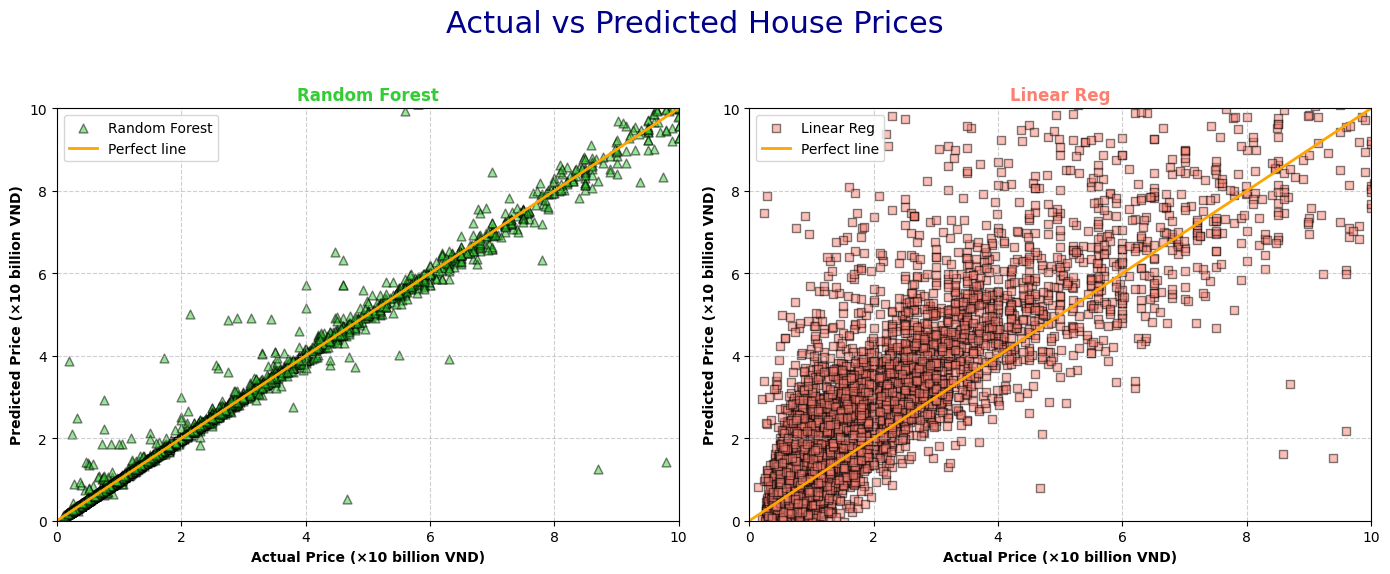

In [12]:
# -------------------------------------------------
# 7. MINH HỌA SCATTER ACTUAL vs PREDICTED
# -------------------------------------------------
import matplotlib.pyplot as plt

models = [("Random Forest", rf_pred, "limegreen",   "^"),
          ("Linear Reg", lr_pred, "salmon", "s")]

plt.figure(figsize=(14,6))
for i, (name, pred, color, marker) in enumerate(models, 1):
    plt.subplot(1,2,i)
    plt.scatter(y_test/10, pred/10, c=color, marker=marker,
                s=40, edgecolors="black", alpha=0.5, label=name)
    plt.plot([0,10], [0,10], "orange", lw=2, label="Perfect line")
    plt.xlim(0,10); plt.ylim(0,10)
    plt.xlabel("Actual Price (×10 billion VND)", fontweight="bold")
    plt.ylabel("Predicted Price (×10 billion VND)", fontweight="bold")
    plt.title(name, fontweight="bold", color=color)
    plt.grid(ls="--", alpha=0.6); plt.legend()

plt.suptitle("Actual vs Predicted House Prices", fontsize=22, color="darkblue")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

In [13]:
# -------------------------------------------------
# 8. IMPORT THƯ VIỆN
# -------------------------------------------------

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
import numpy as np

In [14]:
# -------------------------------------------------
# 9. BASE MODEL (đều bọc trong pipeline có 'prep')
# -------------------------------------------------
rf_pipe = Pipeline([
        ("prep", preprocess),
        ("rf",  RandomForestRegressor(**study.best_params))
])

lin_pipe = Pipeline([
        ("prep", preprocess),
        ("lr",   LinearRegression())
])

In [15]:
# -------------------------------------------------
# 10. META‑MODEL  (RidgeCV cho chắc chắn)
# -------------------------------------------------
meta_model = RidgeCV(alphas=np.logspace(-3,3,13))

In [16]:
# -------------------------------------------------
# 11. STACKING REGRESSION  (K=10 fold, shuffle)
# -------------------------------------------------
stack = StackingRegressor(
        estimators=[('rf', rf_pipe),
                    ('lin', lin_pipe)],
        final_estimator=meta_model,
        cv=KFold(n_splits=10, shuffle=True, random_state=42),
        n_jobs=-1,
        passthrough=False    # chỉ dùng dự báo base model
)

In [17]:
# -------------------------------------------------
# 12. HUẤN LUYỆN
# -------------------------------------------------
stack.fit(X_train, y_train)


StackingRegressor(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                  estimators=[('rf',
                               Pipeline(steps=[('prep',
                                                ColumnTransformer(transformers=[('num',
                                                                                 StandardScaler(),
                                                                                 Index(['price_per_m2', 'area', 'floors', 'toilets', 'bedrooms', 'balcony',
       'street_frontage', 'legal', 'interior', 'year', 'month', 'day'],
      dtype='object')),
                                                                                ('bool',
                                                                                 'passthrough',
                                                                                 Index(['district...
       'district_ThanhXuan', 'district_ThuongTin', 'district_UngHoa'],
      dtype='object'))])),
                                               ('lr', LinearRegression())]))],
                  final_estimator=RidgeCV(alphas=array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])),
                  n_jobs=-1)

In [18]:
# -------------------------------------------------
# 13. ĐÁNH GIÁ DỰA TRÊN TẬP TEST
# -------------------------------------------------
pred_test = stack.predict(X_test)

rmse  = np.sqrt(mean_squared_error(y_test, pred_test))
rmsle = np.sqrt(mean_squared_log_error(
                    np.clip(y_test, 0, None)+1,
                    np.clip(pred_test, 0, None)+1))
r2    = r2_score(y_test, pred_test)

print(f"RMSE  : {rmse:,.3f}")
print(f"RMSLE : {rmsle:.3f}")
print(f"R²    : {r2:.4f}")

RMSE  : 20.716
RMSLE : 0.249
R²    : 0.8195


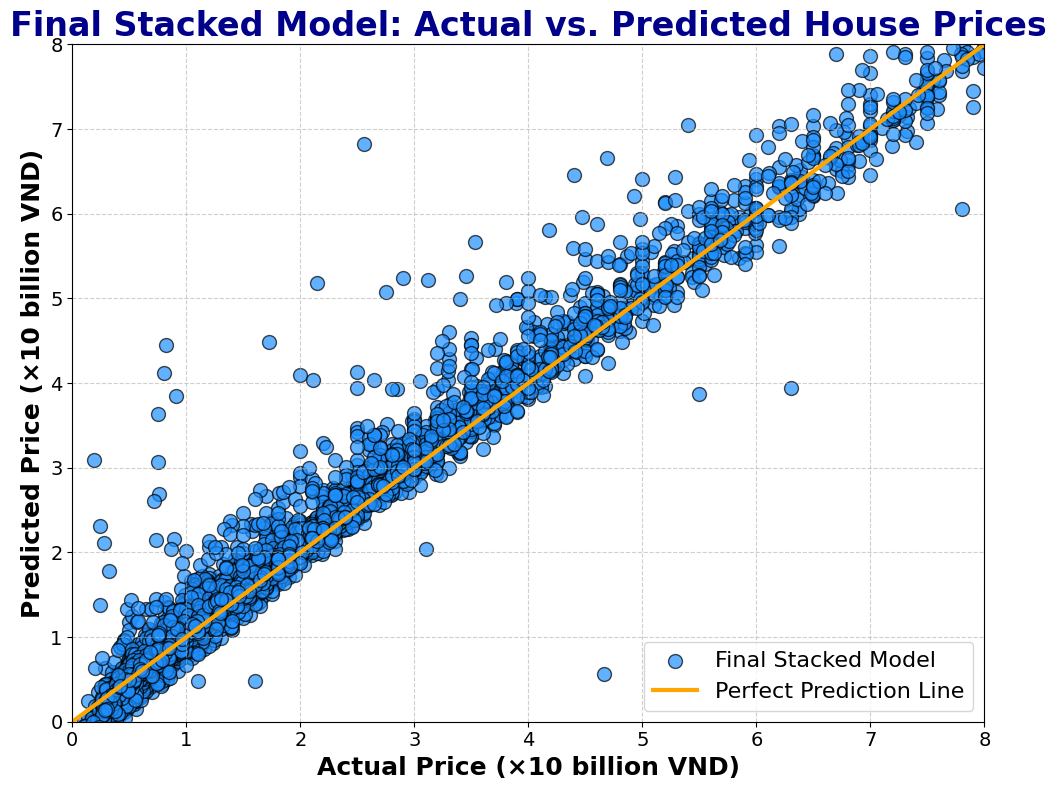

In [19]:
# -------------------------------------------------
# 14. VẼ SCATTER
# -------------------------------------------------
plt.figure(figsize=(10, 8))
plt.title("Final Stacked Model: Actual vs. Predicted House Prices", fontsize=24, fontweight='bold', color='darkblue')

plt.scatter(y_test / 10, pred_test / 10,
            color='dodgerblue', marker='o', edgecolors="black", alpha=0.7, s=100, label="Final Stacked Model")

plt.plot([0, 8], [0, 8], "orange", lw=3, label="Perfect Prediction Line")

plt.xlim(0, 8)
plt.ylim(0, 8)
plt.xlabel("Actual Price (×10 billion VND)", fontsize=18, fontweight='bold')
plt.ylabel("Predicted Price (×10 billion VND)", fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# -------------------------------------------------
# 15. TRIỂN KHAI
# -------------------------------------------------
deploy_pred = stack.predict(X_test)
pd.DataFrame({"Price": deploy_pred}) \
  .to_csv("Submission_Stack_(Rf+Lr).csv", index=False)

print("Saved file: Submission_Stack_(Rf+Lr).csv")

Saved file: Submission_Stack(Rf+Lr).csv
